## Import Necessary Libraries

In [1078]:
import pandas as pd
import tensorflow as tf
import os
import numpy as np
import itertools

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten, \
GlobalAveragePooling2D, BatchNormalization, Resizing, Rescaling, RandomFlip, RandomRotation

from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from keras import models, layers 
from keras_preprocessing.image import load_img, array_to_img, img_to_array, ImageDataGenerator
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import  Adam

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from sklearn.metrics import plot_confusion_matrix, confusion_matrix

## Load the Files of Images

In [1079]:
datagen = ImageDataGenerator()

In [1080]:
train_path =  './data/fruits-360_dataset/fruits-360/Training'
test_path = './data/fruits-360_dataset/fruits-360/Test'
val_path = './data/fruits-360_dataset/fruits-360/Validation'

In [1081]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2, 
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [1082]:
image_size = (100, 100)
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = image_size,
    batch_size = 32,
    color_mode = 'rgb',
    class_mode = 'categorical')

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size = image_size,
    batch_size = 32,
    color_mode = 'rgb',
    class_mode = 'categorical')

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size = image_size,
    batch_size = 32,
    color_mode = 'rgb',
    class_mode = 'categorical')

Found 6019 images belonging to 6 classes.
Found 1751 images belonging to 6 classes.
Found 523 images belonging to 6 classes.


In [1083]:
train_class_names = list(train_generator.class_indices.keys())
train_class_names

['Apple Braeburn',
 'Apple Crimson Snow',
 'Apple Golden',
 'Apple Granny Smith',
 'Apple Pink Lady',
 'Apple Red Delicious']

In [1084]:
test_class_names = list(test_generator.class_indices.keys())
test_class_names

['Apple Braeburn',
 'Apple Crimson Snow',
 'Apple Golden',
 'Apple Granny Smith',
 'Apple Pink Lady',
 'Apple Red Delicious']

In [1085]:
val_class_names = list(val_generator.class_indices.keys())
val_class_names

['Apple Braeburn',
 'Apple Crimson Snow',
 'Apple Golden',
 'Apple Granny Smith',
 'Apple Pink Lady',
 'Apple Red Delicious']

## Begin Modeling

#### Baseline Model

In [1086]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [1087]:
# enc_train_labels = to_categorical(train_labels) #/255
# enc_train_images = to_categorical(train_images)

# enc_test_labels = to_categorical(test_labels)/255
# enc_test_images = to_categorical(test_images)

# enc_val_labels = to_categorical(val_labels)/255
# enc_val_images = to_categorical(val_images)

In [1088]:
# train_img = train_images.reshape(train_images.shape[0], -1)
# test_img = test_images.reshape(test_images.shape[0], -1)
# val_img = val_images.reshape(val_images.shape[0], -1)

In [1089]:
# print(train_img.shape)
# print(test_img.shape)
# print(val_img.shape)

In [1090]:
train_labels

array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0.

In [1091]:
train_images.shape

(32, 100, 100, 3)

In [1092]:
train_labels.shape

(32, 6)

In [1093]:
# train_y = np.reshape(train_labels[:,0], (32, ))
# test_y = np.reshape(test_labels[:,0], (32, ))
# val_y = np.reshape(val_labels[:,0], (32, ))

In [1094]:
#Instantiate a Regularizer
reg = l2(3e-3)

In [1095]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [1096]:
baseline_model = models.Sequential([layers.RandomFlip("horizontal_and_vertical"),
                                   layers.RandomRotation(0.2),])
baseline_model.add(layers.Conv2D(18, (3,3), activation='relu', input_shape=(100, 100, 3))) # 2 hidden layers
baseline_model.add(layers.MaxPooling2D(2,2))
baseline_model.add(layers.Dropout(0.25))
baseline_model.add(layers.Conv2D(36, (3,3), activation='relu')) # 2 hidden layers
baseline_model.add(layers.MaxPooling2D(2,2))
#baseline_model.add(BatchNormalization())
baseline_model.add(layers.Flatten())
baseline_model.add(layers.Dense(36, activation='relu', kernel_regularizer = reg))
baseline_model.add(layers.Dense(48, activation='relu', kernel_regularizer = reg))
#baseline_model.add(layers.Dense(24, activation='relu', kernel_regularizer = reg))
baseline_model.add(layers.Dense(6, activation='softmax', kernel_regularizer = reg))
#Check example of dropout, towrards start, filyters
# CNNS Intro
# 

In [1097]:
train_images.shape

(32, 100, 100, 3)

In [1098]:
train_labels.shape

(32, 6)

In [1099]:
opt = Adam(learning_rate=0.001)
es = EarlyStopping(monitor='val_loss', mode='min')


np.random.seed(42)
baseline_model.compile(optimizer=opt,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

baseline_histoire = baseline_model.fit(train_images,
                                       train_labels,
                                       #callbacks = [es],
                                       epochs = 40,
                                       batch_size = 32,
                                       validation_data = (val_images, val_labels))

Epoch 1/40


2022-12-06 22:49:57.296097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 871ms/step - loss: 2.1675 - accuracy: 0.0312 - val_loss: 2.3696 - val_accuracy: 0.0312
Epoch 2/40
1/1 [==============================] - ETA: 0s - loss: 2.3304 - accuracy: 0.0312

2022-12-06 22:49:57.812482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 136ms/step - loss: 2.3304 - accuracy: 0.0312 - val_loss: 2.0106 - val_accuracy: 0.2500
Epoch 3/40
1/1 [==============================] - 0s 124ms/step - loss: 1.5607 - accuracy: 0.5938 - val_loss: 2.1087 - val_accuracy: 0.2500
Epoch 4/40
1/1 [==============================] - 0s 134ms/step - loss: 1.6439 - accuracy: 0.5938 - val_loss: 2.0458 - val_accuracy: 0.2500
Epoch 5/40
1/1 [==============================] - 0s 135ms/step - loss: 1.5415 - accuracy: 0.5938 - val_loss: 1.9434 - val_accuracy: 0.2500
Epoch 6/40
1/1 [==============================] - 0s 136ms/step - loss: 1.4920 - accuracy: 0.5938 - val_loss: 1.8714 - val_accuracy: 0.2500
Epoch 7/40
1/1 [==============================] - 0s 139ms/step - loss: 1.4458 - accuracy: 0.5938 - val_loss: 1.8462 - val_accuracy: 0.2500
Epoch 8/40
1/1 [==============================] - 0s 132ms/step - loss: 1.4330 - accuracy: 0.5938 - val_loss: 1.8389 - val_accuracy: 0.2500
Epoch 9/40
1/1 [===============

In [1100]:
baseline_model.summary()

Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_24 (RandomFlip)  (32, 100, 100, 3)        0         
                                                                 
 random_rotation_24 (RandomR  (32, 100, 100, 3)        0         
 otation)                                                        
                                                                 
 conv2d_84 (Conv2D)          (32, 98, 98, 18)          504       
                                                                 
 max_pooling2d_84 (MaxPoolin  (32, 49, 49, 18)         0         
 g2D)                                                            
                                                                 
 dropout_56 (Dropout)        (32, 49, 49, 18)          0         
                                                                 
 conv2d_85 (Conv2D)          (32, 47, 47, 36)        

In [1101]:
baseline_results_train = baseline_model.evaluate(train_images, train_labels)
baseline_results_test = baseline_model.evaluate(test_images, test_labels)

1/1 [==============================] - 0s 25ms/step - loss: 1.4721 - accuracy: 0.5000


In [1102]:
print(f'Baseline Train Results: {baseline_results_train}')
print(f'Baseline Test Results: {baseline_results_test}')

Baseline Train Results: [0.893923819065094, 0.78125]
Baseline Test Results: [1.4720780849456787, 0.5]


#### Baseline Model Visualizations

#### Graphing Accuracy and Loss Metrics

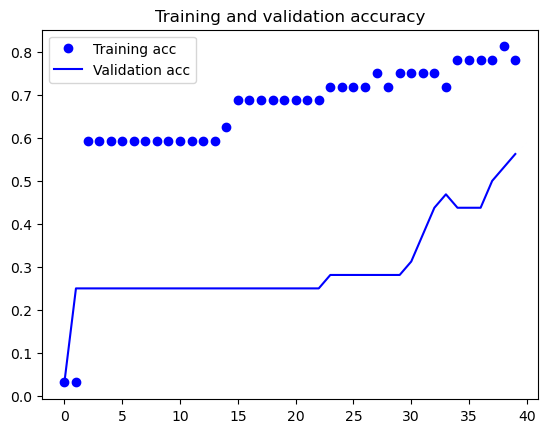

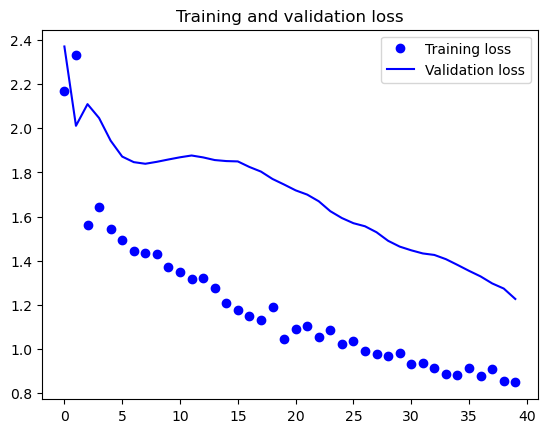

In [1103]:
# Plot history
acc = baseline_histoire.history['accuracy']
val_acc = baseline_histoire.history['val_accuracy']
loss = baseline_histoire.history['loss']
val_loss = baseline_histoire.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show();



#### Confusion Matrix

In [1104]:
test_images.shape

(32, 100, 100, 3)

In [1105]:
baseline_predictions = baseline_model.predict(x = test_images, batch_size = 32, verbose = 0)
baseline_rounded_predictions = np.argmax(baseline_predictions, axis = -1)
baseline_rounded_labels = np.argmax(test_labels, axis=1)
baseline_cm = confusion_matrix(y_true = baseline_rounded_labels, y_pred = baseline_rounded_predictions)

2022-12-06 22:50:02.971649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [1106]:
baseline_predictions

array([[4.40223664e-01, 1.55153975e-01, 1.04108956e-02, 4.52947477e-03,
        1.52263626e-01, 2.37418324e-01],
       [1.20733842e-01, 1.06357463e-01, 1.34368226e-01, 8.09558928e-02,
        1.17390357e-01, 4.40194190e-01],
       [6.08118135e-04, 3.92529415e-03, 5.07700086e-01, 3.36932421e-01,
        6.77657453e-03, 1.44057482e-01],
       [2.87523083e-02, 4.36865278e-02, 2.98920184e-01, 1.64683565e-01,
        7.25883394e-02, 3.91369134e-01],
       [1.39688343e-01, 9.20952559e-02, 8.74808058e-02, 3.89375016e-02,
        9.14114639e-02, 5.50386608e-01],
       [4.50952917e-01, 1.40125930e-01, 8.81099235e-03, 3.20003158e-03,
        1.62989467e-01, 2.33920619e-01],
       [1.99139193e-01, 1.06878459e-01, 9.34235379e-02, 4.76917140e-02,
        1.59629866e-01, 3.93237263e-01],
       [2.44107973e-02, 3.47682498e-02, 2.48393953e-01, 1.77811861e-01,
        4.67781648e-02, 4.67837036e-01],
       [3.55199784e-01, 1.77557662e-01, 2.66920328e-02, 1.60780791e-02,
        1.23804249e-01, 

In [1107]:
baseline_rounded_labels

array([0, 5, 2, 4, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 2, 3, 0, 4, 4, 1, 2, 2,
       2, 0, 2, 1, 2, 3, 3, 0, 5, 2])

In [1108]:
baseline_rounded_labels

array([0, 5, 2, 4, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 2, 3, 0, 4, 4, 1, 2, 2,
       2, 0, 2, 1, 2, 3, 3, 0, 5, 2])

In [1109]:
baseline_rounded_predictions

array([0, 5, 2, 5, 5, 0, 5, 5, 0, 0, 5, 0, 5, 0, 2, 2, 5, 5, 5, 0, 2, 2,
       2, 0, 2, 0, 2, 2, 2, 5, 0, 2])

In [1110]:
# cm_digits = confusion_matrix(y_test, predicted)
# disp = ConfusionMatrixDisplay(
#     confusion_matrix=cm_digits)

# disp.plot(cmap=plt.cm.Blues)
# plt.show()

In [1111]:
# cm_digits = confusion_matrix(y_test, predicted)
# disp = ConfusionMatrixDisplay(
#     confusion_matrix=cm_digits)

# disp.plot(cmap=plt.cm.Blues)
# plt.show()

In [1112]:
def plot_confusion_matrix_func(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='none', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

In [1113]:
cm_plot_labels = test_class_names

Confusion matrix, without normalization
[[3 0 0 0 0 3]
 [2 0 0 0 0 0]
 [0 0 8 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 0 0 3]
 [5 0 0 0 0 5]]


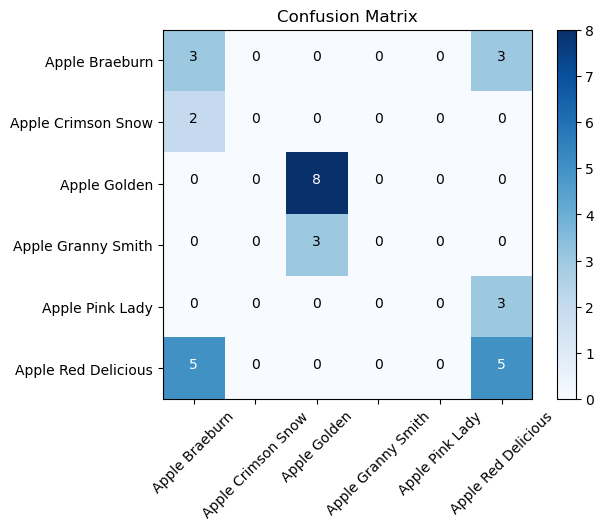

In [1114]:
plot_confusion_matrix_func(cm = baseline_cm, classes = cm_plot_labels, title='Confusion Matrix')

In [1115]:
type(baseline_cm)

numpy.ndarray

In [1116]:
test_labels

array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0.

#### Second Model

In [1117]:
sz = 200

# Initializing the CNN
model1 = Sequential()

# First convolution layer and pooling
model1.add(Convolution2D(32, (3, 3), input_shape=(sz, sz, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size = (2, 2)))

# Second convolution layer and pooling
model1.add(Convolution2D(32, (3, 3), activation='relu'))
# input_shape is going to be the pooled feature maps from the previous convolution layer
model1.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening the layers
model1.add(Flatten(input_shape = (28,28)))

# Adding a fully connected layer
model1.add(Dense(units=96, activation='relu'))
model1.add(Dropout(0.40))
model1.add(Dense(units=32, activation='relu'))
model1.add(Dense(units=24, activation='softmax')) # softmax for more than 2

In [1118]:
model1.summary()

Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_86 (Conv2D)          (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_86 (MaxPoolin  (None, 99, 99, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_87 (Conv2D)          (None, 97, 97, 32)        9248      
                                                                 
 max_pooling2d_87 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 flatten_57 (Flatten)        (None, 73728)             0         
                                                                 
 dense_171 (Dense)           (None, 96)              

In [1119]:
model1.compile(optimizer='adam',
               loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
               metrics=['accuracy'])

In [1120]:
# history = model1.fit(
#     train_generator,
#     validation_data = test_generator,
#     epochs = 5
# )